In [1]:
import pandas as pd
import numpy as np
import os
import sys
import shutil
from random import shuffle

In [2]:
source = './bank.csv' # Original dataset
data_path = './build' # Folder to place the working data
bin_data_file = 'bin_data.csv' # File to store the binarized data

# Creates a directory (or cleans it) to store the training/verification data
if os.path.isdir(data_path):
    try:
        shutil.rmtree(data_path)
    except:
        print ("Deletion of the directory %s failed" % data_path)
        exit(1)
try:
    os.mkdir(data_path, 0o755)
except:
    print ("Creation of the directory %s failed" % data_path)
    exit(1)

In [3]:
# Count how many positive and negative samples are in the dataset
g_pos_total = 0
g_neg_total = 0

df = pd.read_csv(source, header=0, usecols=['y'])
suscriptions = df['y'].tolist()

for x in suscriptions:
    if x == 'yes':
        g_pos_total += 1
    else:
        g_neg_total += 1

print('Positive samples:', g_pos_total)
print('Negative samples:', g_neg_total)

Positive samples: 521
Negative samples: 4000


In [4]:
import matplotlib.pyplot as plt

labels = 'Positive samples', 'Negative samples'
sizes = [g_pos_total, g_neg_total]

fig1, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

<Figure size 640x480 with 1 Axes>

In [29]:
def binarize_data(source):
    headers = ['age_young', 'age_adult', 'age_old',
               'marital_single', 'marital_married', 'marital_divorced',
               'education_primary', 'education_secondary', 'education_tertiary',
               'default', 'housing', 'loan',
               'campaign_lower', 'previous_lower', 'pdays_lower',
               'suscribed']

    balance_lower_bound = 0
    campaign_lower_bound = 1
    previous_lower_bound = 1
    pdays_lower_bound = 100
    bin_data = []
    
    log_chunks = 1000

    i = 0
    for df in pd.read_csv(source, sep=',', header = 0, chunksize=1):
        if (i % 1000 == 0):
            print("Computed %d rows..." % (i))

        if (df['education'][i] == 'unknown'):
            pass

        row = []

        age = int(df['age'][i])
        row += [age < 27, age >= 27 and age <= 65, age > 65]
        row += [df['marital'][i] == 'single', df['marital'][i] == 'married', df['marital'][i] == 'divorced']
        row += [df['education'][i] == 'primary', df['education'][i] == 'secondary', df['education'][i] == 'tertiary']
        row += [df['default'][i] == 'yes']
        row += [df['housing'][i] == 'yes']
        row += [df['loan'][i] == 'yes']
        row += [int(df['campaign'][i]) < campaign_lower_bound]
        row += [int(df['previous'][i]) < previous_lower_bound]
        row += [int(df['pdays'][i]) < pdays_lower_bound]
        row += [df['y'][i] == 'yes']

        bin_data.append(row)
        i += 1
    
    print("Computed %d rows..." % (i))

    return [headers, bin_data]

In [30]:
headers, bin_data = binarize_data(source)

df = pd.DataFrame(bin_data, columns=headers)
df.to_csv(data_path + '/' + bin_data_file, index=False)

Computed 0 rows...
Computed 1000 rows...
Computed 2000 rows...
Computed 3000 rows...
Computed 4000 rows...
Computed 4521 rows...


In [31]:
def k_fold_cross_validation(X, K, randomise = False):
    """
    Generates K (training, validation) pairs from the items in X.

    Each pair is a partition of X, where validation is an iterable
    of length len(X)/K. So each training iterable is of length (K-1)*len(X)/K.

    If randomise is true, a copy of X is shuffled before partitioning,
    otherwise its order is preserved in training and validation.
    """
    if randomise:
        X = list(X)
        shuffle(X)

    for k in range(K):
        training = [x for i, x in enumerate(X) if i % K != k]
        validation = [x for i, x in enumerate(X) if i % K == k]
        yield training, validation, k

In [32]:
n_sets = 7

# Generate training and verification data
with open(data_path + '/' + bin_data_file, 'r') as data:
    data.readline() # Skip first line of headers
    for training, validation, k in k_fold_cross_validation(data.readlines(), K = n_sets, randomise = True):  
        print("Generating %d/%d file" % (k + 1, n_sets))
        tf = open("%s/train_%d.csv" % (data_path, k), 'w')
        tf.writelines(training)
        tv = open("%s/validation_%d.csv" % (data_path, k), 'w')
        tv.writelines(validation)
        tf.close()
        tv.close()

Generating 1/7 file
Generating 2/7 file
Generating 3/7 file
Generating 4/7 file
Generating 5/7 file
Generating 6/7 file
Generating 7/7 file


In [33]:
def parse_file(name):
    df = pd.read_csv(name, sep=',', header=None)
    return df.values.tolist()

In [34]:
def count_classes(X_train):
    # Count how many positive and negative classes there are
    count_pos = 0
    count_neg = 0

    for g in X_train:
        g_class = bool(g[-1])
        count_pos += int(g_class)
        count_neg += int(not g_class)
    
    return [count_pos, count_neg]

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Compute score for each element and classify them as positive or negative classes
alphas = np.linspace(-0.7, 0.2, 31)
y_preds = []
y_real = []

for i in range(n_sets):
    print('Computing set {} of {}'.format(i + 1, n_sets))

    X_train = parse_file(data_path + '/train_' + str(i) + '.csv')
    X_test = parse_file(data_path + '/validation_' + str(i) + '.csv')

    [count_pos, count_neg] = count_classes(X_train)
    y_real = y_real + [bool(x[-1]) for x in X_test]

    for g_t in X_test:
        support_pos = 0
        support_neg = 0

        # Compute support (positive and negative) of the element
        g_t_short = [x for x in g_t][:-1] # Remove last element
        for g in X_train:
            g_class = bool(g[-1])
            g = [x for x in g][:-1]

            support_g = np.sum(np.array(g_t_short) & np.array(g)).item()
            if (g_class):
                support_pos += support_g
            else:
                support_neg += support_g

        support_pos /= count_pos
        support_neg /= count_neg
        score = support_pos - support_neg

        # Add the predicted class
        for i, alpha in enumerate(alphas):
            if len(y_preds) > i:
                y_preds[i].append(score >= alpha)
            else:
                y_preds.append([score >= alpha])

Computing set 1 of 7
Computing set 2 of 7
Computing set 3 of 7
Computing set 4 of 7
Computing set 5 of 7
Computing set 6 of 7
Computing set 7 of 7


In [36]:
stats = []

for i, y_pred in enumerate(y_preds):
    y_real = np.array(y_real)
    y_pred = np.array(y_pred)

    TP = np.sum(y_real & y_pred)
    TN = np.sum(y_real + y_pred == 0)
    FP = np.sum((y_real  == 0) * (y_pred == 1))
    FN = np.sum((y_real  == 1) * (y_pred == 0))
    
    TPR = float(TP) / np.sum(y_real == 1)
    TNR = float(TN) / np.sum(y_real == 0)
    FPR = float(FP) / (FP + TN)
    FNR = float(FN) / (FN + TP)
    NPV = float(TN) / (TN + FN)
    FDR = float(FP) / (TP + FP)
    
    acc = accuracy_score(y_real, y_pred)
    prec = precision_score(y_real, y_pred)
    rec = recall_score(y_real, y_pred)
    f1 = 2 * prec * rec / (prec + rec)
    
    stats_particular = [TP,  TN,  FP,  FN,
                        TPR, TNR, FPR, FNR,
                        NPV, FDR, acc, prec, rec, f1]
    stats.append(stats_particular)

    print('------', alphas[i])
    print("True Positive: {}\nTrue Negative: {}\nFalse Positive: {}\nFalse Negative: {}\n\
True Positive Rate: {}\nTrue Negative Rate: {}\nFalse Positive Rate: {}\nFalse Negative Rate: {}\n\
Negative Predictive Value: {}\nFalse Discovery Rate: {}\nAccuracy: {}\nPrecision: {}\n\
Recall: {}\nF1: {}".format(TP,  TN,  FP,  FN,
                   TPR, TNR, FPR, FNR,
                   NPV, FDR, acc, prec, rec, f1))

------ -0.7
True Positive: 516
True Negative: 162
False Positive: 3838
False Negative: 5
True Positive Rate: 0.9904030710172744
True Negative Rate: 0.0405
False Positive Rate: 0.9595
False Negative Rate: 0.009596928982725527
Negative Predictive Value: 0.9700598802395209
False Discovery Rate: 0.8814882866329812
Accuracy: 0.14996682149966822
Precision: 0.11851171336701884
Recall: 0.9904030710172744
F1: 0.21169230769230768
------ -0.6699999999999999
True Positive: 498
True Negative: 355
False Positive: 3645
False Negative: 23
True Positive Rate: 0.9558541266794626
True Negative Rate: 0.08875
False Positive Rate: 0.91125
False Negative Rate: 0.044145873320537425
Negative Predictive Value: 0.9391534391534392
False Discovery Rate: 0.8797972483707458
Accuracy: 0.18867507188675073
Precision: 0.12020275162925416
Recall: 0.9558541266794626
F1: 0.21355060034305318
------ -0.64
True Positive: 475
True Negative: 786
False Positive: 3214
False Negative: 46
True Positive Rate: 0.9117082533589251
True

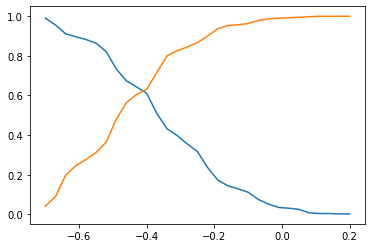

In [37]:
import matplotlib.pyplot as plt

TPRs = [x[4] for x in stats]
TNRs = [x[5] for x in stats]

plt.plot(alphas, TPRs)
plt.plot(alphas, TNRs)
plt.show()


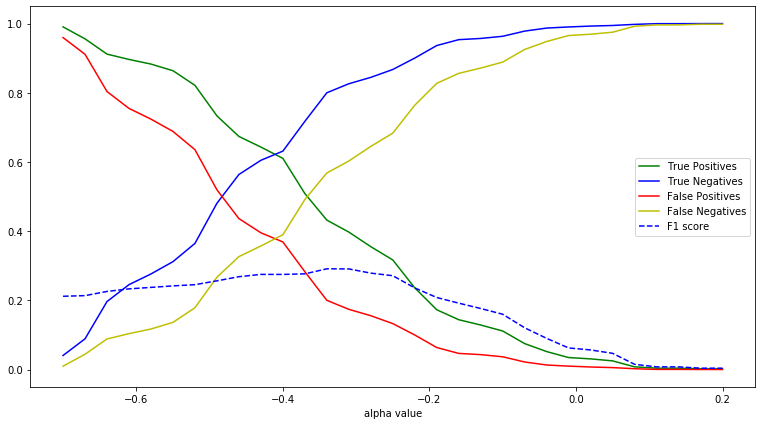

In [41]:
import matplotlib.pyplot as plt

TPR = [x[4] for x in stats]
TNR = [x[5] for x in stats]
FPR = [x[6] for x in stats]
FNR = [x[7] for x in stats]
f1 = [x[13] for x in stats]

plt.figure(figsize=(13,7))
plt.plot(alphas, TPR, color='g', label='True Positives')
plt.plot(alphas, TNR, color='b', label='True Negatives')
plt.plot(alphas, FPR, color='r', label='False Positives')
plt.plot(alphas, FNR, color='y', label='False Negatives')
plt.plot(alphas, f1, '--', color='b', label='F1 score')
plt.xlabel('alpha value')
plt.legend()
plt.show()


In [39]:
import copy

# Generate latex table
headers = ['TP',  'TN',  'FP',  'FN',
           'Acc', 'Prec', 'Rec', 'F1']

cstats = copy.deepcopy(stats)
for i, x in enumerate(cstats):
    del cstats[i][4:10]

print("\\begin{table}[ht]")
print("\\centering")
print("\\begin{tabular}{c|" + ('l|' * len(headers)) +"}")
print("\cline{1-" + str(len(headers) + 1) + "}")

print("\\multicolumn{1}{|c|}{$\\alpha$} ", end='')
for h in headers:
    print("& \\textbf{" + h + "} ", end='')
print("\\\\ \hline")

for i, s in enumerate(cstats):
    print("\\multicolumn{1}{|c|}{\\textbf{" + str(round(alphas[i], 2)) + "}} ", end='')
    for x in s:
        print("& " + str(round(x, 3)) + " ", end='')
    print("\\\\ \hline")

print("\end{tabular}")
print("\end{table}")


\begin{table}[ht]
\begin{tabular}{c|l|l|l|l|l|l|l|l|}
\cline{2-9}
\multicolumn{1}{l|}{} & \textbf{TP} & \textbf{TN} & \textbf{FP} & \textbf{FN} & \textbf{Acc} & \textbf{Prec} & \textbf{Rec} & \textbf{F1} \\ \hline
\multicolumn{1}{|c|}{\textbf{-0.7}} & 516 & 162 & 3838 & 5 & 0.15 & 0.119 & 0.99 & 0.212 \\ \hline
\multicolumn{1}{|c|}{\textbf{-0.67}} & 498 & 355 & 3645 & 23 & 0.189 & 0.12 & 0.956 & 0.214 \\ \hline
\multicolumn{1}{|c|}{\textbf{-0.64}} & 475 & 786 & 3214 & 46 & 0.279 & 0.129 & 0.912 & 0.226 \\ \hline
\multicolumn{1}{|c|}{\textbf{-0.61}} & 467 & 981 & 3019 & 54 & 0.32 & 0.134 & 0.896 & 0.233 \\ \hline
\multicolumn{1}{|c|}{\textbf{-0.58}} & 460 & 1105 & 2895 & 61 & 0.346 & 0.137 & 0.883 & 0.237 \\ \hline
\multicolumn{1}{|c|}{\textbf{-0.55}} & 450 & 1247 & 2753 & 71 & 0.375 & 0.14 & 0.864 & 0.242 \\ \hline
\multicolumn{1}{|c|}{\textbf{-0.52}} & 428 & 1458 & 2542 & 93 & 0.417 & 0.144 & 0.821 & 0.245 \\ \hline
\multicolumn{1}{|c|}{\textbf{-0.49}} & 382 & 1922 & 2078 & 139 & 0.51